# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy\
matplotlib\
json\
nest_asyncio\
jsonpath_ng\
ruamel.yaml\
cwl_utils
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [42]:
# General packages
import pandas as pd         
import os
from tqdm import tqdm       
import pickle
import numpy as np
from datetime import datetime, timedelta
import glob
import sys
import matplotlib.pyplot as plt
import json


# define format, and set parameters for time, TODO: rm?  
date_format = "%Y_%m_%d_%H_%M" 
current_date = datetime.now().strftime(date_format)
last_week_date = (datetime.now() - timedelta(days=7)).strftime(date_format)



# Project specific packages
import aiohttp              # Used for aggregating requests into single session
import asyncio              # -"-
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops
import jsonpath_ng as jp


# TODO: import jsonpath_ng.ext      # More efficient json processing look into if actually computationally more efficient 
import igraph               # Used to create te citationa graph 
import requests             # For single API requests 

# workflow parsing 
from cwl_utils.parser import load_document_by_uri, save # for workflow parsing 
from ruamel import yaml



# Visualisation 
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work

Check that the packages are installed and functional 

In [43]:
print("igraph version:", igraph.__version__)
try: 
    dir(p4c)
    p4c.cytoscape_ping() 
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")


igraph version: 0.11.4
Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!


In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


## Downloading data 

In [44]:
import WFQC.data
help(WFQC.data)

Help on module WFQC.data in WFQC:

NAME
    WFQC.data - Functions to download data.

FUNCTIONS
    async aggregate_requests(session, url)
        Sync the bio.tools (page) requests so they are all made in a single session

        Parameters
        ----------
        session : aiohttp.client.ClientSession object
            session object for package aiohttp
        url : str
            url for request

    europepmc(article_id, format='JSON', source='MED', page=1, page_size=1000)
        Downloads pmids for the articles citing the given article_id, returns list of citation pmids (PubMed IDs)

        Parameters
        ----------
        article_id : str # TODO: int?
            pmid, PubMed ID, for a given article.
        source: str
            source ID as given by the EuropePMC API documentation: https://europepmc.org/Help#contentsources

        page, int, default == 1
            determines where to start looking TODO: remove this, why would you not start at 1?

        pages

## Graph generation

In [45]:
from WFQC.network import create_citation_network 
help(create_citation_network)

Help on function create_citation_network in module WFQC.network:

create_citation_network(topicID='topic_0121', testSize=None, randomSeed=42, loadData=True, filePath='', outpath=None, inpath='', saveFiles=True)
    Creates a citation network given a topic and returns a graph and the tools included in the graph


    Parameters
    ----------
    topicID : str, default "topic_0121" (proteomics) TODO: int?
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)

    testSize : int or None, default None
        Determines the number of tools included in the citation graph.

    randomSeed : int, default 42
        Specifies what seed is used to randomly pick tools in a test run.

    loadData : Boolean, default True
        Determines if already generated graph is loaded or if it is recreated.

    filePath : str  TODO: add filepath
        Path to already generated

The function reate_citation_network can be called to create or load the cocitation network

## The metric

Create the cocitation network specifying if you want to load existing data, run on a smaller test set etc.  

In [46]:
#TODO: filepath for input files! - change bio.tools thing 

G, included_tools = create_citation_network(inpath="out")


Bio.tools data loaded from existing CSV file.
Loading saved graph.


In [47]:
print(len(included_tools))

1091


### Download workflow data


<div class="alert alert-block alert-warning">
<b>OBS:</b> This is not yet implemented. Currently drawing random tools to simulate workflows
</div>

In [10]:
from WFQC.workflow import parse_workflows, radnomise_workflows
from WFQC.metrics import comet

In [48]:
cwl_file = "./workflows/candidate_workflow_2.cwl"

workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = 3)

print(workflow_pairs, rand_workflow_pairs)

[('23051804', '23148064'), ('14632076', '23051804')] [('27575624', '32517646'), ('33529337', '37580331'), ('16026613', '35571557')]


could add visualisation of the workflows and the original workflows. 

### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

In [49]:
# For one workflow
metric_score, raw_results = comet(G, workflow_pairs)

print(raw_results)

print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[55, 22]
Total cocitation score for workflow [('23051804', '23148064'), ('14632076', '23051804')] is 38.5.


### Evaluate results 

Below I am comparing the workflows from workflomics, to completely randomly drawn tools from the bioinformatics topic 

In [12]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have 

In [37]:
workflows = []
rand_workflows = []

#TODO: make this a function?
for i in range(1, 25):
    cwl_file = f"./workflows/candidate_workflow_{i}.cwl" #TODO: customise path!!
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        print("no", cwl_file)
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

no ./workflows/candidate_workflow_8.cwl
no ./workflows/candidate_workflow_9.cwl
no ./workflows/candidate_workflow_18.cwl
no ./workflows/candidate_workflow_19.cwl
[[('12403597', '14976030'), ('14632076', '12403597')], [('23051804', '23148064'), ('14632076', '23051804')], [('12403597', '23148064'), ('14632076', '12403597')], [('29400476', '23148064'), ('29400476', '14632076'), ('14632076', '23148064')], [('29400476', '14632076'), ('29400476', '14976030'), ('14632076', '14976030')], [('29400476', '23148064'), ('29400476', '14632076'), ('14632076', '23148064')], [('14976030', '33538780'), ('14632076', '14976030'), ('33538780', '23148064')], [('29400476', '33538780'), ('33538780', '23148064'), ('29400476', '23148064'), ('29400476', '14632076'), ('14632076', '23148064')], [('12403597', '23148064'), ('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '12403597')], [('29400476', '14632076'), ('29400476', '14976030'), ('14632076', '23148064')], [('12403597', '23051804'), ('23051804

In [38]:
print(len(workflows), len( rand_workflows))

20 20


In [39]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = comet(G, workflows[i])
    rand_metric_score, rand_raw_results = comet(G, rand_workflows[i])

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    
print(rand_scores, scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.25, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25] [289.5, 38.5, 324.0, 27.0, 18.333333333333332, 27.0, 16.0, 16.4, 58.25, 26.0, 196.66666666666666, 162.5, 23.666666666666668, 19.333333333333332, 27.0, 18.333333333333332, 19.333333333333332, 26.0, 18.333333333333332, 35.25]


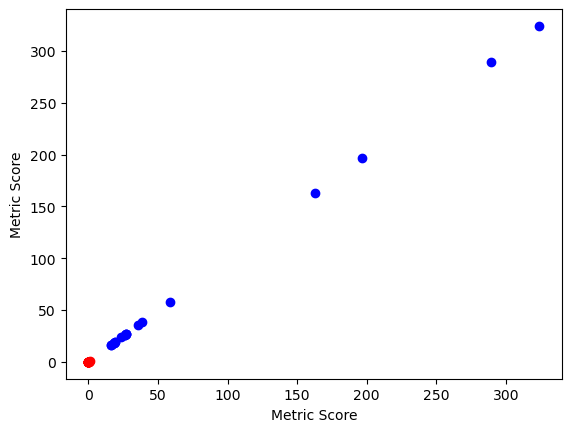

In [40]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.show()


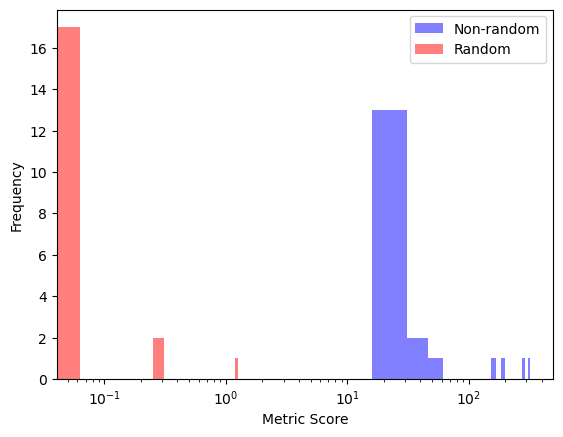

In [41]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # because otherwise not showing up in same plot for some reason

# Show plot
plt.show()


Obviously this comparison is not very fair and we should make sure that the "functional workflows" are drawn from the same set as the randoms, whereas now they are drawn from a very small subset of very well annotated tools. This is more to show that the comparison works, not that the results are reliable. 

## Visualisation


Using cytoscape to visualise the network

In [179]:

import time # TODO: i switched to datetime, fix this later 
t = time.localtime()
current_time = time.strftime("%Y%m%d%H%M", t)


p4c.create_network_from_igraph(G, f"Cocitations_Size{len(included_tools)}_{current_time}", collection="Citation networks")


print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

# colour the tools in the workflow 
p4c.set_node_color_bypass(workflow_tools, "#2F739A")  # they should be gradually coloured later maybe, sequentially
p4c.set_node_size_bypass(workflow_tools, 200)  # remember it cannot be a np.array, just a list argh 


Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''